# Reading Table 3 from the paper. 
Language statistics of single common crawl snapshot.

In [1]:
import tabula
import pandas as pd

file_name = "1911.00359.pdf"

table_list = tabula.read_pdf(file_name, 
                      pages=[7, 8, 9],
                           pandas_options={'header': None 
                                           },
                             lattice=False
                           )
table_list[0].drop(index=0, inplace=True)
column_headers = ['Language', 'Documents', 'Sentences', 'Tokens', 'Size_in_bytes']
for i in table_list:
    i.columns = column_headers
table_combined = pd.concat(table_list, axis=0, ignore_index=True)
table_combined.head(4)

,Language,Documents,Sentences,Tokens,Size_in_bytes
0,af,73.232× 103,5.390× 106,73.041× 106,160.015× 106
1,als,7.615× 103,324.334× 103,3.526× 106,9.977× 106
2,am,54.182× 103,1.533× 106,27.561× 106,98.878× 106
3,an,1.264× 103,16.818× 103,213.407× 103,824.466× 103


# Convert numbers from string-to-float

In [2]:
columns_to_convert = ['Documents', 'Sentences', 'Tokens', 'Size_in_bytes']

for col in columns_to_convert:
    table_combined[[f'{col}_base', f'{col}_exponent']] = table_combined[col].str.split('× 10', expand= True)
    table_combined[f'{col}_base'] = table_combined[f'{col}_base'].astype(float)
    table_combined[f'{col}_exponent'] = table_combined[f'{col}_exponent'].astype(float)
    table_combined[f'{col}'] = table_combined[f'{col}_base']*10**table_combined[f'{col}_exponent']
    table_combined.drop(columns=f'{col}_base', inplace=True)
    table_combined.drop(columns=f'{col}_exponent', inplace=True)

In [3]:
table_combined.dtypes

Language          object
Documents        float64
Sentences        float64
Tokens           float64
Size_in_bytes    float64
dtype: object

# Mapping two-letter language codes to language names

In [4]:
import requests
response = requests.get('https://en.wikipedia.org/wiki/List_of_ISO_639-1_codes')
lang_iso_code = pd.read_html(response.text)
lang_iso_code = lang_iso_code[0]

In [5]:
from os.path import exists
if exists('lang_iso_code.csv'):
    lang_iso_code = pd.read_csv('lang_iso_code.csv', index_col=0)
else:
    try:
        import requests
        response = requests.get('https://en.wikipedia.org/wiki/List_of_ISO_639-1_codes')
        lang_iso_code = pd.read_html(response.text)
        lang_iso_code = lang_iso_code[0]
    except E:
        # TODO: Lenghth check needs to be implemented.
        print(E)

In [6]:
lang_iso_code.head(4)

,ISO language name,639-1,639-2/T,639-2/B,639-3,Notes
0,Abkhazian,ab,abk,abk,abk,also known as Abkhaz
1,Afar,aa,aar,aar,aar,NaN
2,Afrikaans,af,afr,afr,afr,NaN
3,Akan,ak,aka,aka,aka + 2,"macrolanguage, Twi is tw/twi, Fanti is fat"


In [7]:
table_combined = table_combined.merge(lang_iso_code, how='left', left_on = 'Language', right_on = '639-1')

# Gettiing number of users for each languages

In [8]:
from os.path import exists

def string_to_num(inp_string):
    """Function to convert the exmaple string 
        '1.452 billion' into 1.452x1e9 float number
        '1.442 million' into 1.442x1e6 float number    
    """
    try:
        [num, qual_str] = inp_string.split(' ')
        num = float(num)
        if qual_str == 'million':
            qual_str = 1e6
        elif qual_str == 'billion':
            qual_str = 1e9
        return num*qual_str
    except:
        return 0

if exists('language_speaker_map.csv'):
    language_speaker_df = pd.read_csv('language_speaker_map.csv', index_col=0)
else:
    try:
        import requests
        response = requests.get('https://en.wikipedia.org/wiki/List_of_languages_by_total_number_of_speakers')
        language_speaker_df = pd.read_html(response.text)
        language_speaker_df = language_speaker_df[3]
        # Removing reference strings from number strings
        language_speaker_df['First-language(L1) speakers'] = language_speaker_df['First-language(L1) speakers'].str.replace(r'\[[a-z\d]+\]', '', regex=True)
        language_speaker_df['Second-language(L2) speakers'] = language_speaker_df['Second-language(L2) speakers'].str.replace(r'\[[a-z\d]+\]', '', regex=True)
        language_speaker_df['First-language(L1) speakers'] = language_speaker_df['First-language(L1) speakers'].apply(string_to_num)
        language_speaker_df['Second-language(L2) speakers'] = language_speaker_df['Second-language(L2) speakers'].apply(string_to_num)
        language_speaker_df['Total speakers(L1+L2)'] = language_speaker_df['Total speakers(L1+L2)'].apply(string_to_num)
    except E:
        # TODO: Lenghth check needs to be implemented.
        print(E)

In [9]:
# language_speaker_df.to_csv('language_speaker_map.csv')

In [10]:
language_speaker_df.head(5)

,Language,Family,Branch,First-language(L1) speakers,Second-language(L2) speakers,Total speakers(L1+L2),lang_map,lang_mapped
0,English,Indo-European,Germanic,372900000.0,1.080000e+09,1.452000e+09,English,English
1,"Mandarin Chinese(incl. Standard Chinese, but e...",Sino-Tibetan,Sinitic,929000000.0,1.987000e+08,1.118000e+09,"Mandarin Chinese(incl. Standard Chinese, but e...",Chinese
2,Hindi(excl. Urdu),Indo-European,Indo-Aryan,343900000.0,2.583000e+08,6.022000e+08,Hindi(excl. Urdu),Hindi
3,Spanish,Indo-European,Romance,474700000.0,7.360000e+07,5.483000e+08,Spanish,"Spanish, Castilian"
4,French,Indo-European,Romance,79900000.0,1.942000e+08,2.741000e+08,French,French


In [11]:
# # Converting total speaker column - From String to Float

# def string_to_num(inp_string):
#     try:
#         [num, qual_str] = inp_string.split(' ')
#         num = float(num)
#         if qual_str == 'million':
#             qual_str = 1e6
#         elif qual_str == 'billion':
#             qual_str = 1e9
#         return num*qual_str
#     except:
#         return 0

# # string_to_num('1.452 billion')
# language_speaker_df['First-language(L1) speakers'] = language_speaker_df['First-language(L1) speakers'].apply(string_to_num)
# language_speaker_df['Second-language(L2) speakers'] = language_speaker_df['Second-language(L2) speakers'].apply(string_to_num)
# language_speaker_df['Total speakers(L1+L2)'] = language_speaker_df['Total speakers(L1+L2)'].apply(string_to_num)


In [12]:
# Data validation check
language_speaker_df[(language_speaker_df['Total speakers(L1+L2)'] 
                     - language_speaker_df['First-language(L1) speakers'] 
                     - language_speaker_df['Second-language(L2) speakers']).abs() > 1e5]

,Language,Family,Branch,First-language(L1) speakers,Second-language(L2) speakers,Total speakers(L1+L2),lang_map,lang_mapped
0,English,Indo-European,Germanic,372900000.0,1.080000e+09,1.452000e+09,English,English
1,"Mandarin Chinese(incl. Standard Chinese, but e...",Sino-Tibetan,Sinitic,929000000.0,1.987000e+08,1.118000e+09,"Mandarin Chinese(incl. Standard Chinese, but e...",Chinese
22,Korean,Koreanic,—,0.0,0.000000e+00,8.170000e+07,Korean,Korean
25,Egyptian Spoken Arabic(excl. other Arabic dial...,Afro-Asiatic,Semitic,0.0,0.000000e+00,7.480000e+07,Egyptian Spoken Arabic(excl. other Arabic dial...,Arabic
27,Javanese,Austronesian,Malayo-Polynesian,0.0,0.000000e+00,6.830000e+07,Javanese,Javanese
29,Western Punjabi(excl. Eastern Punjabi),Indo-European,Indo-Aryan,0.0,0.000000e+00,6.640000e+07,Western Punjabi(excl. Eastern Punjabi),NaN
37,Jin Chinese,Sino-Tibetan,Sinitic,0.0,0.000000e+00,4.710000e+07,Jin Chinese,Chinese


Looks like string to number conversion was successfull. Difference between sum("First Language Speaker" + "Second Language Speaker") and "Total speakers" are greater than 0.1 million languages where first and second language data are unavailable (Korean, Punjabi, Egyptian Arabic, Javanese) or English|Chinese.

English and Chinese are not surprising entries here, since these are the largest speaker numbers and rounding errors will have larger consequences.

# Fuzzy mapping of language names from table_combined df to language names in language_speaker_df

In [13]:
# https://www.statology.org/fuzzy-matching-pandas/
import difflib

language_speaker_df['lang_map'] = language_speaker_df.Language
language_speaker_df['lang_mapped'] = language_speaker_df.lang_map.apply(lambda x: difflib.get_close_matches(x, 
                                                                       table_combined[table_combined['ISO language name'].notna()]['ISO language name'], cutoff=.8))

def extract_lang_from_list(inp_list):
    '''Extract top match from the list of matching languages'''
    if len(inp_list) == 0:
        return ''
    else:
        return inp_list[0]
language_speaker_df.lang_mapped = language_speaker_df.lang_mapped.apply(extract_lang_from_list)

In [14]:
# Seems like there are still empty maps!
(language_speaker_df.lang_mapped.str.len() ==0).sum()

23

In [15]:
# Trying to map unmatched language names from the two tables

combined_table_lang_names = set(table_combined['ISO language name'][table_combined['ISO language name'].notna()])
speaker_table_lang_names = set(language_speaker_df.lang_map[language_speaker_df.lang_map.notna()])

lang_map_dict = dict()
for i in combined_table_lang_names:
    for j in speaker_table_lang_names:
        i_split = i.split(',')
        if any([x in j.split('(excl. ')[0] for x in i_split]):   # Making sure that (i) alternate names are checked
            if i not in lang_map_dict.keys():                    # and (ii) excluded languages are not mapped.
                lang_map_dict[i] = [j]
            else:
                lang_map_dict[i].append(j)
# lang_map_dict

In [16]:
def value_to_key_map(input_dict, input_value):
    for key in input_dict.keys():
        if input_value in input_dict[key]:
            return key

for i in language_speaker_df[['lang_map', 'lang_mapped']].index:
    if language_speaker_df.loc[i, 'lang_mapped'] == '':
        language_speaker_df.loc[i, 'lang_mapped'] = value_to_key_map(lang_map_dict, language_speaker_df.loc[i, 'lang_map'])

In [17]:
# Still unmapped languages
language_speaker_df.lang_mapped.isna().sum()

7

In [18]:
language_speaker_df_selected = language_speaker_df[language_speaker_df.lang_mapped.notna()]
speaker_by_language = language_speaker_df_selected.groupby(by='lang_mapped').sum().reset_index()[['lang_mapped', 'Total speakers(L1+L2)']] # This combines speakers with different versions of the same language. For example, all Arabic speaker stats (Saudi Arabia Arabic, Egyptian Arabic, Syrian Arabic etc.) will be combined to arabic.
speaker_by_language.columns = ['language', 'total_speakers']

# Combining language stat with speaker by language stat

In [19]:
table_lang_docs_plus_speakers = table_combined.merge(speaker_by_language,how='left', left_on='ISO language name', right_on='language')
table_lang_docs_plus_speakers_notna = table_lang_docs_plus_speakers[table_lang_docs_plus_speakers.total_speakers.notna()].copy(deep=True)

# Comparing language webpage stat @CommonCrawl with language speaker data

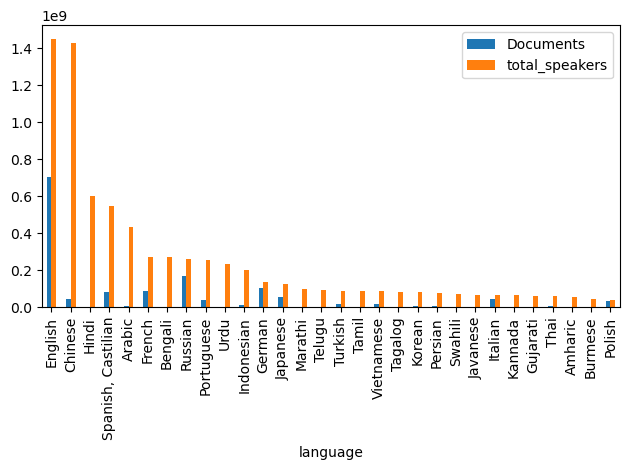

In [20]:
import matplotlib.pyplot as plt

df1 = table_lang_docs_plus_speakers_notna[['language', 'Documents', 'total_speakers']].sort_values(by='total_speakers', ascending=False)
df1.set_index('language', inplace=True)
df1.plot.bar(rot=90)
plt.tight_layout()
plt.show()

## Documents by language (sorted by document numbers)

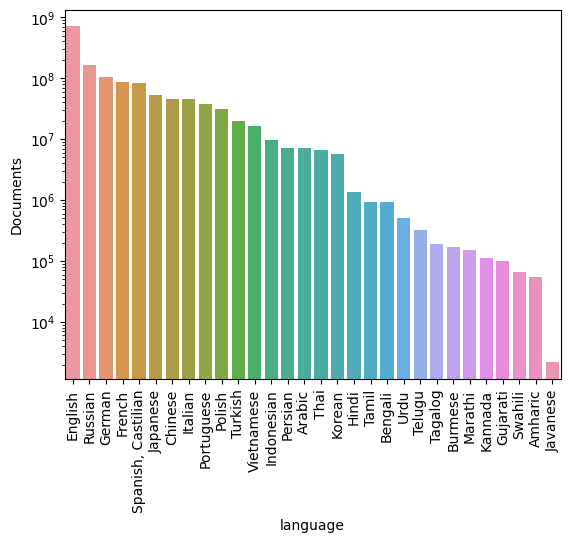

In [21]:
import seaborn as sns
plt.xticks(rotation=90)
g = sns.barplot(data=table_lang_docs_plus_speakers_notna.sort_values(by='Documents', ascending=False), x='language', y='Documents')
g.set_yscale("log")
plt.show()

## Speaker by language (sorted by speakers)

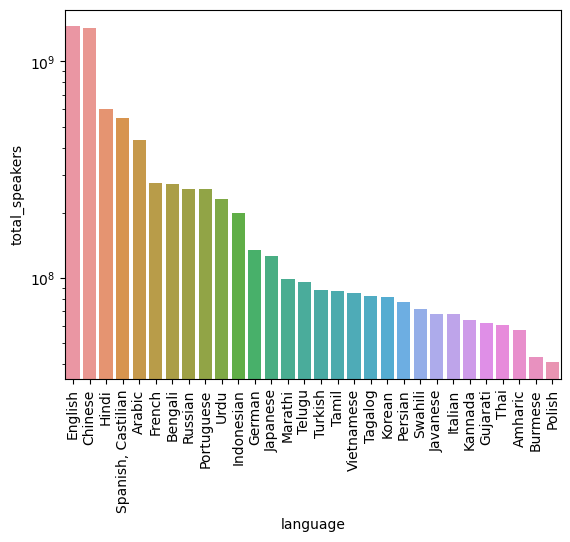

In [22]:
plt.xticks(rotation=90)
g = sns.barplot(data=table_lang_docs_plus_speakers_notna.sort_values(by='total_speakers', ascending=False), x='language', y='total_speakers')
g.set_yscale("log")
plt.show()

## Per speaker number of pages in Feb 2019 CommonCrawl snapshot

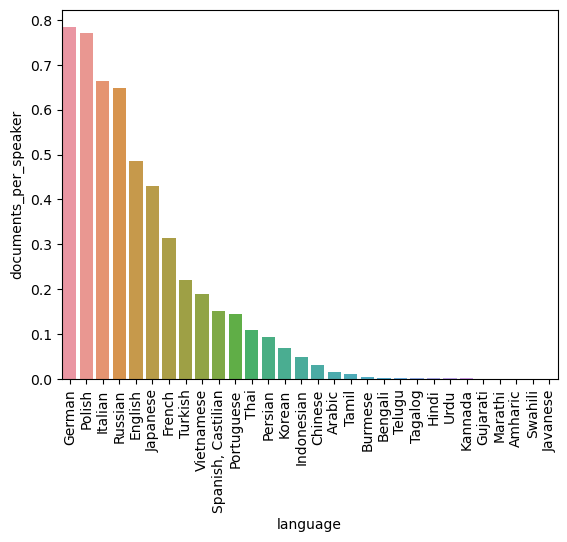

In [23]:
table_lang_docs_plus_speakers_notna['documents_per_speaker'] = table_lang_docs_plus_speakers_notna.Documents/table_lang_docs_plus_speakers_notna.total_speakers
table_lang_docs_plus_speakers_notna
plt.xticks(rotation=90)
g = sns.barplot(data=table_lang_docs_plus_speakers_notna.sort_values(by='documents_per_speaker', ascending=False), x='language', y='documents_per_speaker')
# g.set_yscale('log')
plt.show()

In [24]:
table_lang_docs_plus_speakers_notna['documents_per_100_speakers'] = (table_lang_docs_plus_speakers_notna.documents_per_speaker*100).round(2)
table_lang_docs_plus_speakers_notna[['language', 'documents_per_100_speakers']].sort_values(by='documents_per_100_speakers', ascending=False).head(2)

,language,documents_per_100_speakers
26,German,78.32
92,Polish,76.95


## Per speaker CommonCrawl corpus size

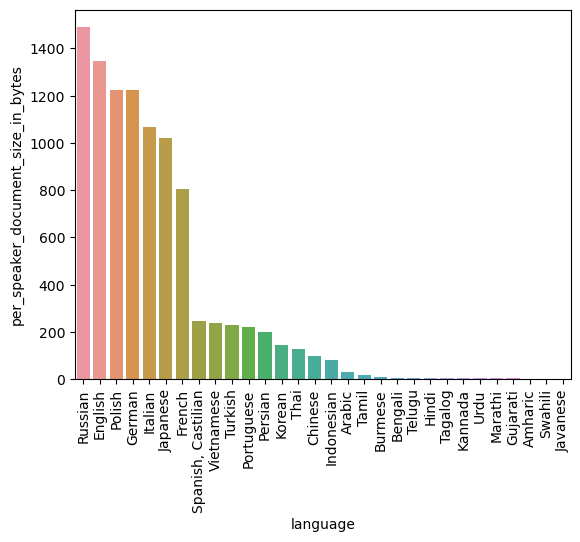

In [25]:
table_lang_docs_plus_speakers_notna['per_speaker_document_size_in_bytes'] = table_lang_docs_plus_speakers_notna.Size_in_bytes/ table_lang_docs_plus_speakers_notna.total_speakers
plt.xticks(rotation=90)
g = sns.barplot(data=table_lang_docs_plus_speakers_notna.sort_values(by='per_speaker_document_size_in_bytes', ascending=False), x='language', y='per_speaker_document_size_in_bytes')
plt.show()

## Per document size

<AxesSubplot:xlabel='language', ylabel='Per_Document_Size'>

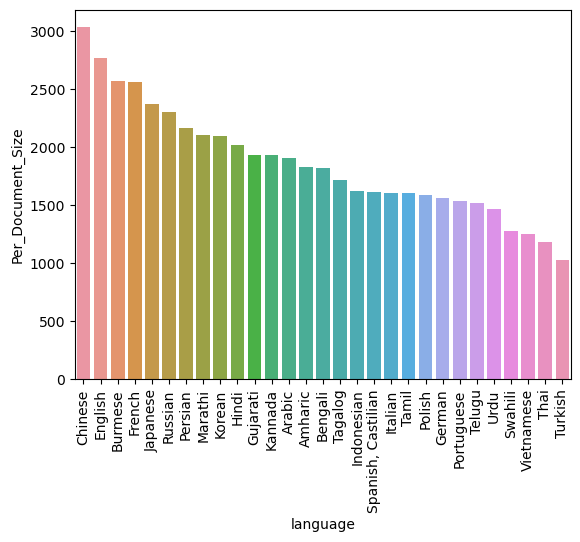

In [26]:
table_lang_docs_plus_speakers_notna['Per_Document_Size'] = table_lang_docs_plus_speakers_notna.Size_in_bytes/table_lang_docs_plus_speakers_notna.Documents
df_slice_to_plot = table_lang_docs_plus_speakers_notna[table_lang_docs_plus_speakers_notna.Documents > 1e4].sort_values(by='Per_Document_Size', ascending=False)
plt.xticks(rotation=90)
sns.barplot(data=df_slice_to_plot, x= 'language', y='Per_Document_Size')

## Per document number of sentences

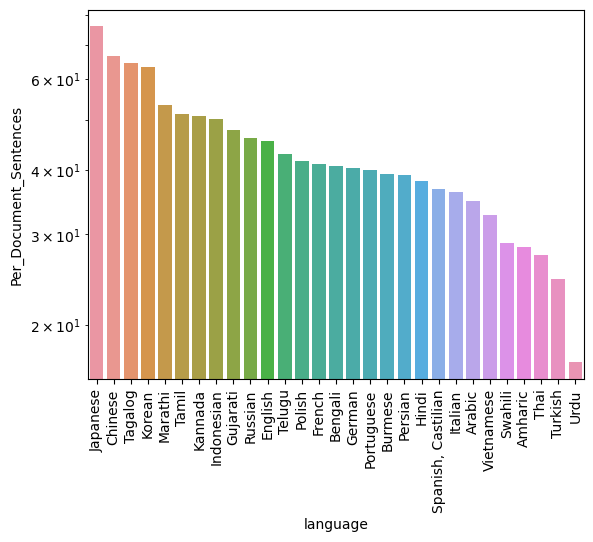

In [27]:
table_lang_docs_plus_speakers_notna['Per_Document_Sentences'] = table_lang_docs_plus_speakers_notna.Sentences/table_lang_docs_plus_speakers_notna.Documents
df_slice_to_plot = table_lang_docs_plus_speakers_notna[table_lang_docs_plus_speakers_notna.Documents > 1e4].sort_values(by='Per_Document_Sentences', ascending=False)
plt.xticks(rotation=90)
g = sns.barplot(data=df_slice_to_plot, x='language', y='Per_Document_Sentences')
g.set_yscale("log")
plt.show()

# Normalizing sizes based on bytes used for each character

Based on the following info:

* Anything up to U+007F takes 1 byte: Basic Latin
* Then up to U+07FF it takes 2 bytes: Greek, Arabic, Cyrillic, Hebrew, etc
* Then up to U+FFFF it takes 3 bytes: Chinese, Japanese, Korean, Devanagari, etc
* Beyond that it takes 4 bytes



In [28]:
# Roughly based on 
#  * https://stackoverflow.com/questions/14485589/utf-8-how-many-bytes-are-used-by-languages-to-represent-a-visible-character
#  * https://stackoverflow.com/questions/14303677/languages-supported-by-latin-vs-latin-extended-glyphs-in-fonts-on-google-web

lang_unicode_byte_map = {'Amharic': 3,
 'Arabic': 2,
 'Bengali': 3,
 'German': 1.2,
 'English': 1,
 'Spanish, Castilian': 1.2,
 'Persian': 2,
 'French': 1.2,
 'Gujarati': 3,
 'Hindi': 3,
 'Indonesian': 3,
 'Italian': 1.2,
 'Japanese': 3,
 'Javanese': 3,
 'Kannada': 3,
 'Korean': 3,
 'Marathi': 3,
 'Burmese': 3,
 'Polish': 2,
 'Portuguese': 1.2,
 'Russian': 2,
 'Swahili': 2,
 'Tamil': 3,
 'Telugu': 3,
 'Thai': 3,
 'Tagalog': 3,
 'Turkish': 1.2,
 'Urdu': 2,
 'Vietnamese': 3,
 'Chinese': 3}

lang_unicode_byte_map = pd.Series(lang_unicode_byte_map, name='language_byte_factor')

table_lang_docs_plus_speakers_notna = table_lang_docs_plus_speakers_notna.merge(lang_unicode_byte_map, how='left', left_on='language', right_index=True)

In [29]:
table_lang_docs_plus_speakers_notna['normalized_size_in_Latin_bytes_equivalent'] = table_lang_docs_plus_speakers_notna.Size_in_bytes /table_lang_docs_plus_speakers_notna.language_byte_factor

## Plotting normalized Latin bytes equivalent

<AxesSubplot:xlabel='language', ylabel='Per_Document_Latin_Normalized_Size'>

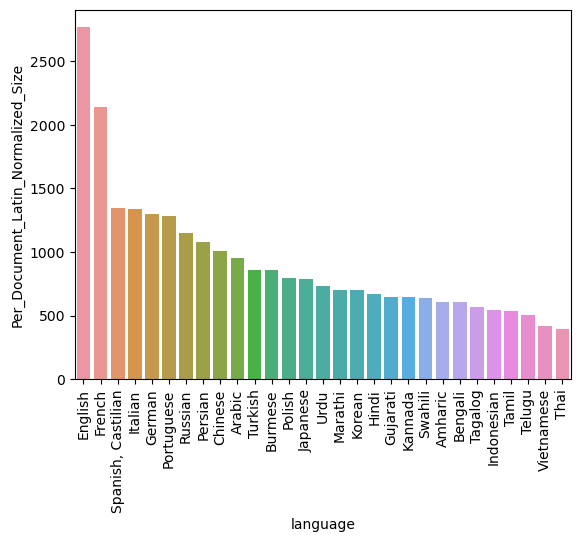

In [30]:
table_lang_docs_plus_speakers_notna['Per_Document_Latin_Normalized_Size'] = table_lang_docs_plus_speakers_notna.normalized_size_in_Latin_bytes_equivalent/table_lang_docs_plus_speakers_notna.Documents
df_slice_to_plot = table_lang_docs_plus_speakers_notna[table_lang_docs_plus_speakers_notna.Documents > 1e4].sort_values(by='Per_Document_Latin_Normalized_Size', ascending=False)
plt.xticks(rotation=90)
sns.barplot(data=df_slice_to_plot, x= 'language', y='Per_Document_Latin_Normalized_Size')

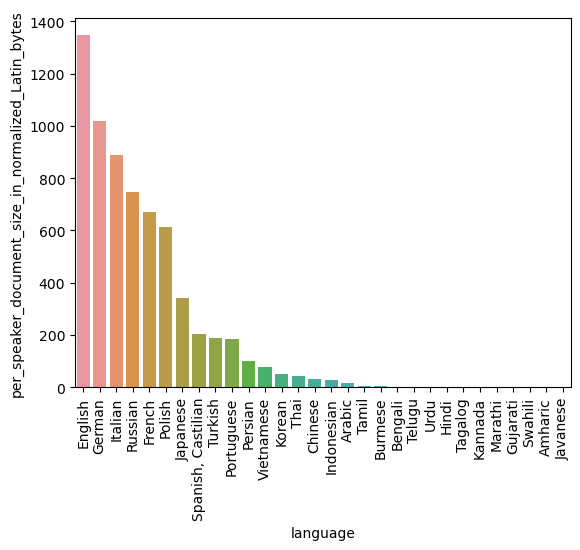

In [31]:
table_lang_docs_plus_speakers_notna['per_speaker_document_size_in_normalized_Latin_bytes'] = table_lang_docs_plus_speakers_notna.normalized_size_in_Latin_bytes_equivalent/ table_lang_docs_plus_speakers_notna.total_speakers
plt.xticks(rotation=90)
g = sns.barplot(data=table_lang_docs_plus_speakers_notna.sort_values(by='per_speaker_document_size_in_normalized_Latin_bytes', ascending=False), x='language', y='per_speaker_document_size_in_normalized_Latin_bytes')
plt.show()